# Fibre throughput

Given that the individual fibres on an IFU have different efficiencies, the light collected by each of them will be different. To correct this, the relative "throughput" of each fibre need to be estimated. This is done usually by means of observing an homogeneous field such as a twilight or dome flat.

In [4]:
from matplotlib import pyplot as plt
import numpy as np
from pykoala import __version__
import warnings
import os

from pykoala.instruments.koala_ifu import koala_rss
from pykoala.corrections.throughput import Throughput, ThroughputCorrection
from pykoala.plotting.qc_plot import qc_throughput

# You may want to comment the following line
warnings.filterwarnings("ignore")
print("pyKOALA version: ", __version__)

pyKOALA version:  0.11.3+26.gba65c29.dirty


## Estimate the fibre throughput using 4 skyflat exposures

In this example, we will be using sky flat fields (twilights) to build the throughput map. For comparison, we will store the resulting throughput map from each RSS to compare with the combined throughput.

In pyKOALA, fibre throughput models are represented by the *Throughput* class, which allows to easily load and save them in fits format compatible with the rest of the pipeline. This class is then used to apply the Throughput Correction (see e.g. reduction_sequence_std_stars tutorial)

To create a throughput from a list of RSS files, we can make use of the method in the *ThroughputCorrection.create_throughput_from_rss*

In [5]:
ThroughputCorrection.create_throughput_from_rss?

Signature:
ThroughputCorrection.create_throughput_from_rss(
    rss_set,
    clear_nan=True,
    statistic='median',
    medfilt=None,
)
Docstring:
Compute the throughput map from a set of flat exposures.

Given a set of flat exposures, this method will estimate the average
efficiency of each fibre.

Parameters
----------
- rss_set: (list)
    List of RSS data.
- clean_nan: (bool, optional, default=True)
    If True, nan values will be replaced by a
    nearest neighbour interpolation.
- statistic: (str, optional, default='median')
    Set to 'median' or 'mean' to compute the throughput function.
- medfilt: (float, optional, default=None)
    If provided, apply a median filter to the throughput estimate.
File:      ~/naive_user/pykoala/src/pykoala/corrections/throughput.py
Type:      function

In [12]:
skyflat_rss = [ ]
individual_throughputs = []
for n in range(13, 17):
    rss = koala_rss(os.path.join("data", "koala/throughput_files", f"22feb100{n}red.fits"))
    skyflat_rss.append(rss)

    ind_throughput = ThroughputCorrection.create_throughput_from_rss([rss], clear_nan=True, statistic='median')
    individual_throughputs.append(ind_throughput)

[Log]  Initialising history log

> Reading RSS file 22feb10013red.fits created with None ...

  Number of spectra in this RSS = 1000 ,  number of good spectra = 986  ,  number of bad spectra = 14
  Bad fibres = [109, 110, 235, 424, 574, 607, 675, 714, 721, 722, 723, 793, 950, 951]
[Log]  Initialising history log
Nearest neighbour interpolation to remove NaN values
[Log]  Initialising history log

> Reading RSS file 22feb10014red.fits created with None ...

  Number of spectra in this RSS = 1000 ,  number of good spectra = 986  ,  number of bad spectra = 14
  Bad fibres = [109, 110, 235, 424, 574, 607, 675, 714, 721, 722, 723, 793, 950, 951]
[Log]  Initialising history log
Nearest neighbour interpolation to remove NaN values
[Log]  Initialising history log

> Reading RSS file 22feb10015red.fits created with None ...

  Number of spectra in this RSS = 1000 ,  number of good spectra = 986  ,  number of bad spectra = 14
  Bad fibres = [109, 110, 235, 424, 574, 607, 675, 714, 721, 722, 723,

### Combined throughput

Let's now make a throughput using all the RSS files and applying some smoothing using a median filter

In [13]:
throughput = ThroughputCorrection.create_throughput_from_rss(skyflat_rss, clear_nan=True, statistic='median',
                                                             medfilt=None)

Nearest neighbour interpolation to remove NaN values


If you would like to dump a throughput into a fits file, you just need to provide the appropriate path to the desired file

In [15]:
throughput.tofits(os.path.join("data", "koala/throughput_files", "example_throughput.fits"))

[Throughput] Throughput saved at data/koala/throughput_files/example_throughput.fits


To load a throughput simple instance a *Throughput* object

In [17]:
throughput = Throughput(path=os.path.join("data", "koala/throughput_files","example_throughput.fits"))

[Throughput] Loading throughput from data/koala/throughput_files/example_throughput.fits


In [18]:
np.nanmedian(throughput.throughput_data / throughput.throughput_error)

2.208575487867191

#### Some quality control plots

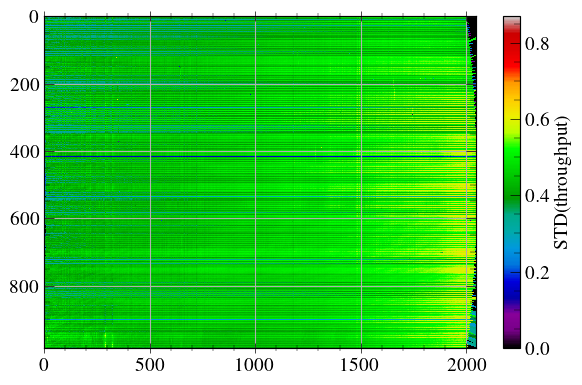

In [19]:
plt.figure()
plt.imshow(throughput.throughput_error, aspect='auto',  interpolation='none', cmap='nipy_spectral')
plt.colorbar(label="STD(throughput)")

Text(0, 0.5, 'Relative throughput')

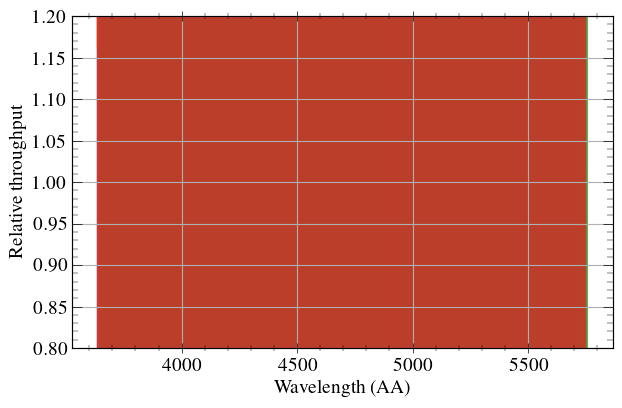

In [20]:
plt.figure()
for i in [133, 300, 500, 700]:
    plt.fill_between(rss.wavelength,
                     throughput.throughput_data[i] - 2 * throughput.throughput_error[i],
                     throughput.throughput_data[i] + 2* throughput.throughput_error[i], alpha=0.8)

plt.ylim(0.8, 1.2)
plt.xlabel("Wavelength (AA)")
plt.ylabel("Relative throughput")
    

## Make a final QC throughput plot

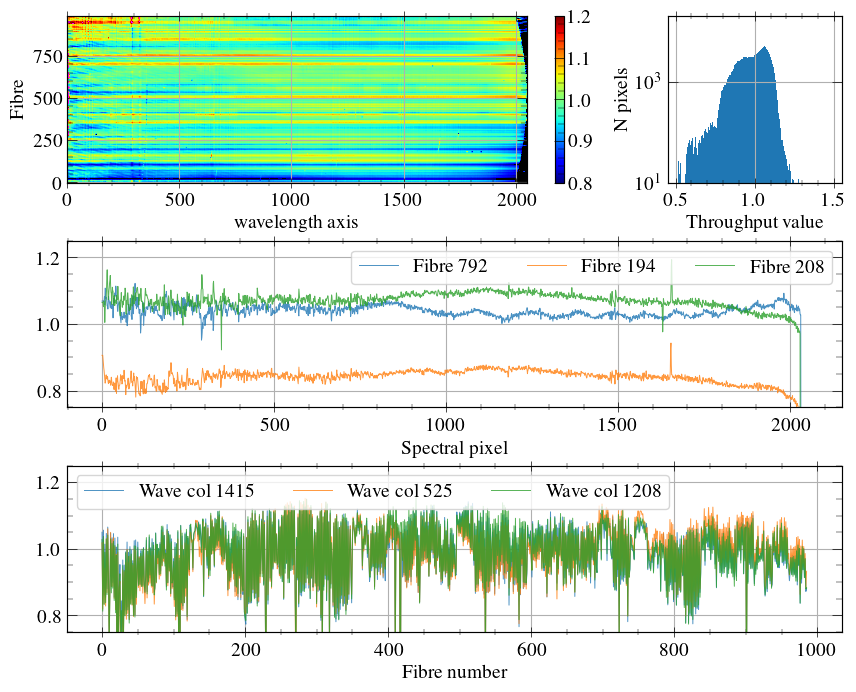

In [21]:
throughput_fig = qc_throughput(throughput)
plt.show(throughput_fig)